# Chapter 2  Scripts for running basic experiments on Theory

In [1]:
#import packages and verify versions

# numpy
import numpy
print('numpy: %s' % numpy.__version__)
# scipy
import scipy
print('scipy: %s' % scipy.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas
print('pandas: %s' % pandas.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)


numpy: 1.15.4
scipy: 0.19.1
matplotlib: 2.1.0
pandas: 0.20.3
sklearn: 0.19.1


Automatically created module for IPython interactive environment


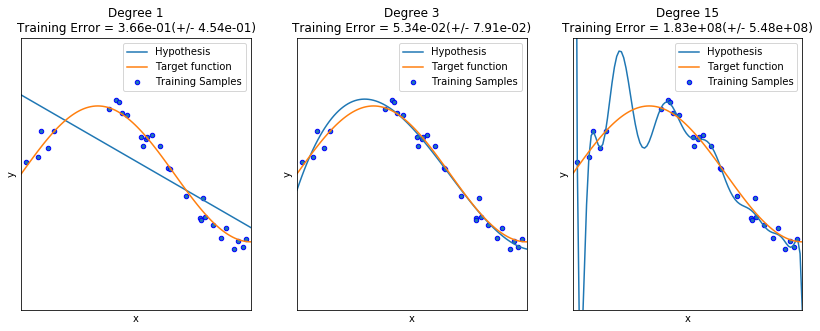

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
print(__doc__)


def true_fun(X):
    return np.sin(1.5 * np.pi * X)


np.random.seed(0)

n_samples = 30
degrees = [1, 3, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(
        X_test[:, np.newaxis]), label="Hypothesis")
    plt.plot(X_test, true_fun(X_test), label="Target function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Training Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nTraining Error = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()


# Bias Variance Error 
Polynomial Regression with degree 1 and degree 12 both trying to fit a target function dawn from sine function in one dimension to illustrate bias, variance and total error

Automatically created module for IPython interactive environment
Poly deg=1: 0.2062 (error) = 0.1870 (bias^2)  + 0.0089 (var) + 0.0098 (noise)
Poly deg=12: 2.5249 (error) = 0.0453 (bias^2)  + 2.4698 (var) + 0.0098 (noise)


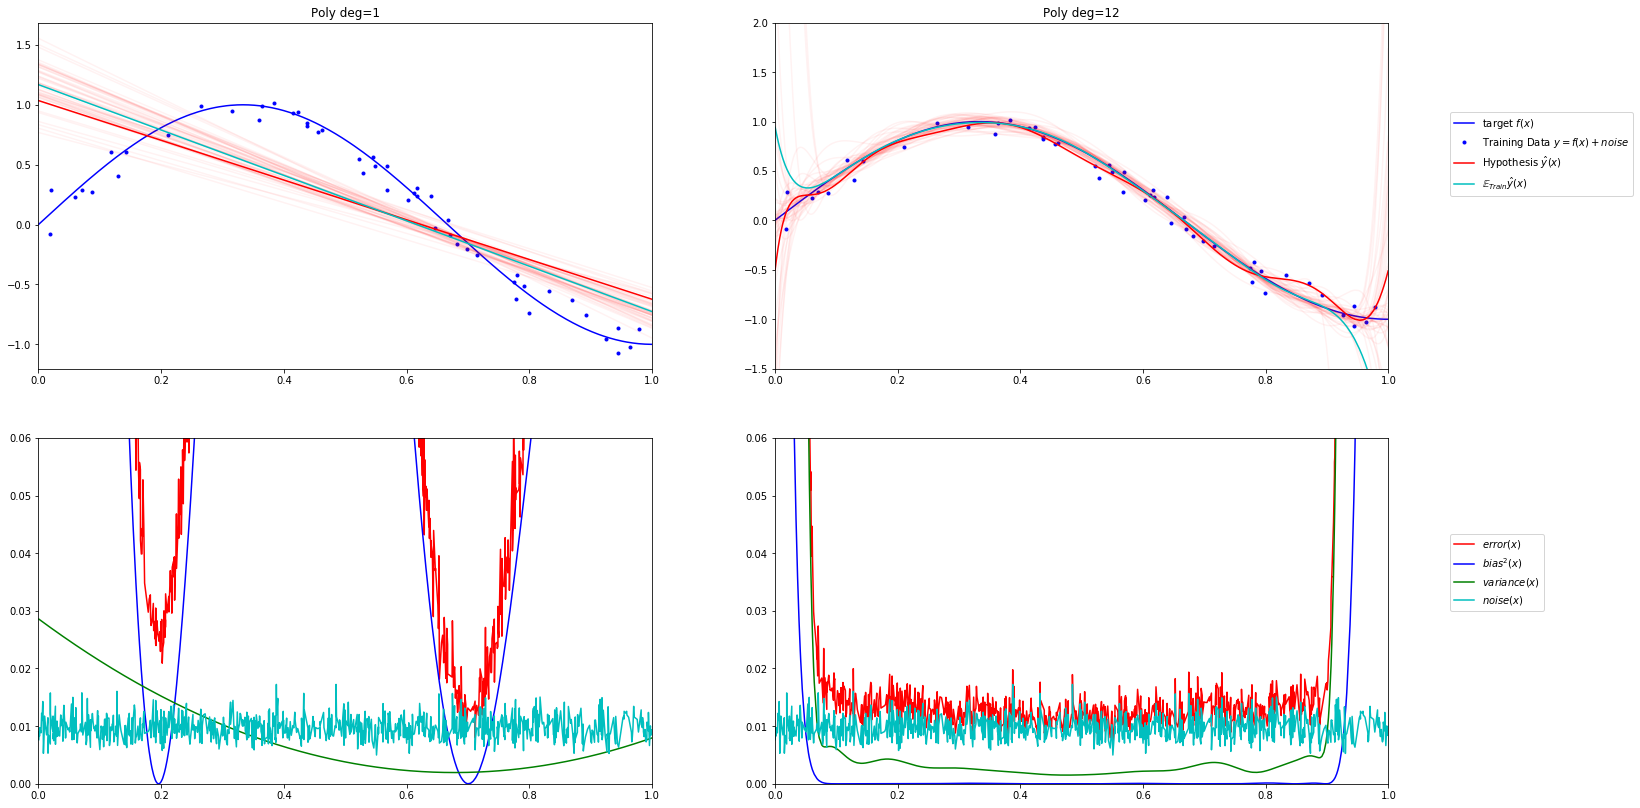

In [3]:
print(__doc__)

# Author: Gilles Louppe <g.louppe@gmail.com>, Uday Kamath<kamathuday@gmail.com>
# License: BSD 3 clause
# extended this code and changed it to reflect bias, variance and error

import numpy as np
import matplotlib.pyplot as plt



# Settings
n_repeat = 50       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000       # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(0)

# three polynomials with degree 1, 
# and degree 12 polynomial. The impact on bias, variance and error on all three
# can be seen through this example.
polynomial_features1 = PolynomialFeatures(degree=1,
                                             include_bias=False)
linear_regression1= LinearRegression()
pipeline1 = Pipeline([("polynomial_features", polynomial_features1),
                        ("linear_regression", linear_regression1)])

polynomial_features2 = PolynomialFeatures(degree=1,
                                             include_bias=False)

polynomial_features3 = PolynomialFeatures(degree=12,
                                             include_bias=False)
linear_regression3= LinearRegression()
pipeline3 = Pipeline([("polynomial_features", polynomial_features3),
                        ("linear_regression", linear_regression3)])
estimators = [("Poly deg=1", pipeline1), ("Poly deg=12", pipeline3)]

n_estimators = len(estimators)


# Generate data with sine function
def f(x):
    x = x.ravel()

    return np.sin(1.5 * np.pi * x)


def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) 
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y


X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

plt.figure(figsize=(30, 14))

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="target $f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="Training Data $y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label="Hypothesis $\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label="$\mathbb{E}_{Train} \^y(x)$")

    plt.xlim([0, 1])
    plt.title(name)

    if n == n_estimators - 1:
        plt.ylim([-1.5,2])
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([0, 1])
    plt.ylim([0, 0.06])

    if n == n_estimators - 1:

        plt.legend(loc=(1.1, .5))

plt.subplots_adjust(right=.75)
plt.show()

# Feature Transformation and Linear Model in transformed Z space showing Kernels in action

Automatically created module for IPython interactive environment


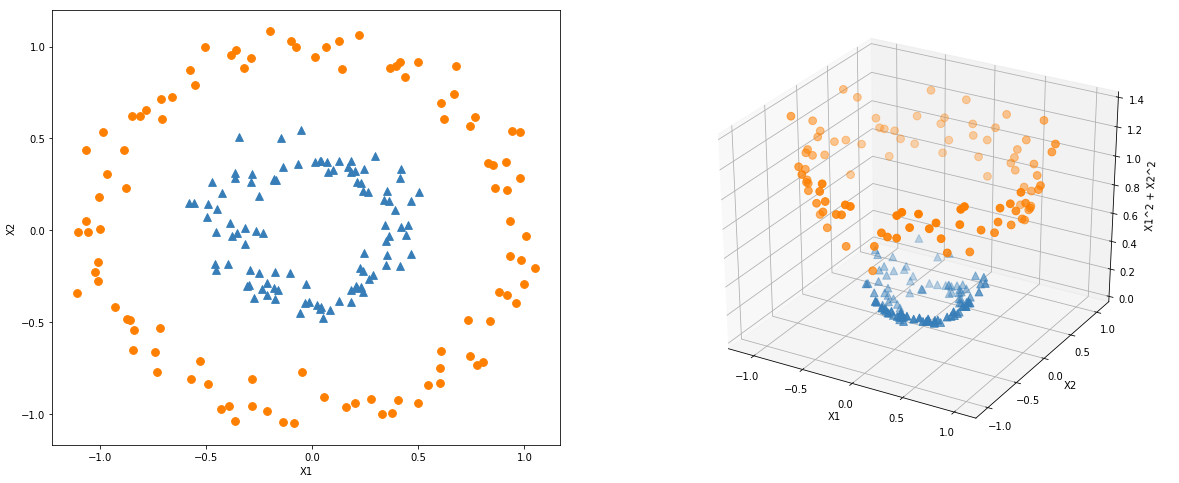

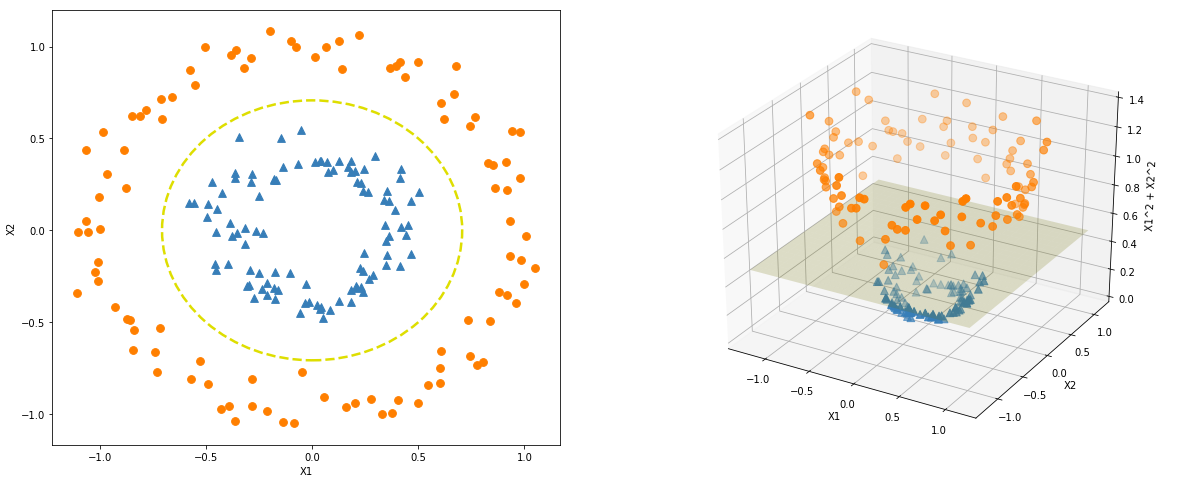

In [4]:
print(__doc__)

import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from math import sqrt
from sklearn.datasets import make_circles



def transform(x1, x2):
    # Transforms a kernel phi(x1,x2) = [x1, x2, x1^2 + x2^2] """
    return np.array([x1, x2, x1**2.0 + x2**2.0])

    
n = 200
X, Y = make_circles(n_samples=n, noise=0.07, factor=0.4)

A = X[np.where(Y == 0)]
B = X[np.where(Y == 1)]

X0_orig = A[:, 0]
Y0_orig = A[:, 1]

X1_orig = B[:, 0]
Y1_orig = B[:, 1]



A = np.array([transform(x,y) for x,y in zip(np.ravel(X0_orig), np.ravel(Y0_orig))])
X0 = A[:, 0]
Y0 = A[:, 1]
Z0 = A[:, 2]

A = np.array([transform(x,y) for x,y in zip(np.ravel(X1_orig), np.ravel(Y1_orig))])
X1 = A[:, 0]
Y1 = A[:, 1]
Z1 = A[:, 2]

x = np.arange(-1.25, 1.25, 0.1)
y = np.arange(-1.25, 1.25, 0.1)
X, Y = np.meshgrid(x, y)

Z = np.zeros(X.shape)
Z[:,:] = 0.5

#Plot without Decision Boundary
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(122, projection='3d')

ax.scatter(X0, Y0, Z0,s=60, c='#ff7f00', marker='o')
ax.scatter(X1, Y1, Z1,s=60, c='#377eb8', marker='^')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X1^2 + X2^2')
#ax.set_title("Feature space in R^3")

# Project data to X/Y plane
#plt.figure(figsize=(10,4))
ax2d = fig.add_subplot(121)
ax2d.scatter(X0, Y0, c='#ff7f00', s=60,marker='o')
ax2d.scatter(X1, Y1, c='#377eb8',s=60, marker='^')

ax2d.set_xlabel('X1')
ax2d.set_ylabel('X2')
#ax2d.set_title("Input space in R^2")

plt.show()


# Plot with Decision Boundary
fig = plt.figure(figsize=(20,8))
# Project data to X/Y plane
ax2d = fig.add_subplot(121)
ax2d.scatter(X0, Y0, c='#ff7f00', s=60,marker='o')
ax2d.scatter(X1, Y1, c='#377eb8',s=60, marker='^')


ax2d.add_patch(plt.Circle((0,0), radius=sqrt(0.5),
               fill=False, linestyle='dashed', linewidth=2.5,
               color='#dede00'))

ax2d.set_xlabel('X1')
ax2d.set_ylabel('X2')
#ax2d.set_title("Input space in R^2")
#plt.figure(figsize=(10,4))
ax = fig.add_subplot(122, projection='3d')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X1^2 + X2^2')
#ax.set_title("Feature space in R^3")
ax.scatter(X0, Y0, Z0,s=60, c='#ff7f00', marker='o')
ax.scatter(X1, Y1, Z1,s=60, c='#377eb8', marker='^')
ax.plot_surface(X, Y, Z, color='#dede00', alpha=0.2, antialiased=True)

plt.show()


# Optimization using Gradient Descent

Gradient Descent: -3.73, 82.80 73
Least Squares: -3.71, 82.90


/Users/udaykamath/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'color'
  s)


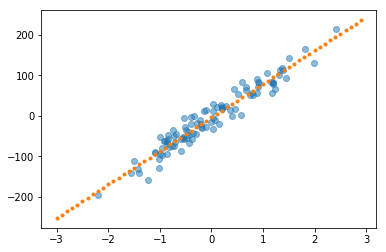

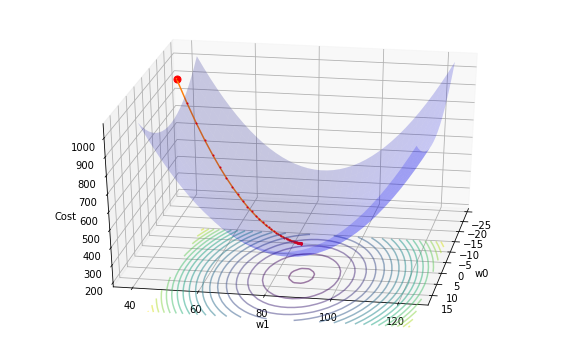

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats 

from sklearn.datasets.samples_generator import make_regression

#code adapted from http://tillbergmann.com/blog/python-gradient-descent.html
x, y = make_regression(n_samples = 100, 
                       n_features=1, 
                       n_informative=1, 
                       noise=20,
                       random_state=2017)
x = x.flatten()
slope, intercept, _,_,_ = stats.linregress(X,y)
best_fit = np.vectorize(lambda x: x * slope + intercept)
plt.plot(x,y, 'o', alpha=0.5)
grid = np.arange(-3,3,0.1)
plt.plot(grid,best_fit(grid), '.')

#code adapted from https://am207.github.io/
def gradient_descent(x, y, theta_init, step=0.001, maxsteps=0, precision=0.001, ):
    costs = []
    m = y.size # number of data points
    theta = theta_init
    history = [] # to store all thetas
    preds = []
    counter = 0
    old_cost = 0
    pred = np.dot(x, theta)
    error = pred - y 
    current_cost = np.sum(error ** 2) / (2 * m)
    preds.append(pred)
    costs.append(current_cost)
    history.append(theta)
    counter+=1
    while abs(current_cost - old_cost) > precision:
        old_cost=current_cost
        gradient = x.T.dot(error)/m 
        theta = theta - step * gradient  # update
        history.append(theta)
        
        pred = np.dot(x, theta)
        error = pred - y 
        current_cost = np.sum(error ** 2) / (2 * m)
        costs.append(current_cost)
        
        if counter % 25 == 0: preds.append(pred)
        counter+=1
        if maxsteps:
            if counter == maxsteps:
                break
        
    return history, costs, preds, counter

xaug = np.c_[np.ones(x.shape[0]), x]
theta_i = [-15, 40] + np.random.rand(2)
history, cost, preds, iters = gradient_descent(xaug, y, theta_i, step=0.1)
theta = history[-1]

print("Gradient Descent: {:.2f}, {:.2f} {:d}".format(theta[0], theta[1], iters))
print("Least Squares: {:.2f}, {:.2f}".format(intercept, slope))

from mpl_toolkits.mplot3d import Axes3D

def error(x, y, THETA):
    return np.sum((x.dot(THETA) - y)**2)/(2*y.size)

ms = np.linspace(theta[0] - 20 , theta[0] + 20, 20)
bs = np.linspace(theta[1] - 40 , theta[1] + 40, 40)

M, B = np.meshgrid(ms, bs)

zs = np.array([error(xaug, y, theta) 
               for theta in zip(np.ravel(M), np.ravel(B))])
Z = zs.reshape(M.shape)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(M, B, Z, rstride=1, cstride=1, color='b', alpha=0.2)
ax.contour(M, B, Z, 20, color='b', alpha=0.5, offset=0, stride=30)


ax.set_xlabel('w0')
ax.set_ylabel('w1')
ax.set_zlabel('Cost')
ax.view_init(elev=30., azim=10)
ax.plot([history[0][0]], [history[0][1]], [cost[0]] , markerfacecolor='r', markeredgecolor='r', marker='o', markersize=7);


ax.plot([t[0] for t in history], [t[1] for t in history], cost , markerfacecolor='r', markeredgecolor='r', marker='.', markersize=2);
plt.show()

# Optimization using Stochastic Gradient Descent

/Users/udaykamath/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'color'
  s)


[-25.15242431  -0.81125188] [1.         0.03225343] 11.534851890155354 -13.617572416568379 -25.15242430672373 316.32222425273335
start 1 [316.32222425273335] 0


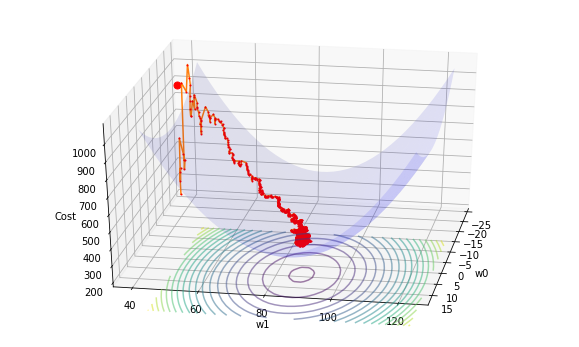

In [13]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.datasets.samples_generator import make_regression


def sgd(x, y, theta_init, step=0.001, maxsteps=0, precision=0.001, ):
    costs = []
    m = y.size  # number of data points
    old_theta = 0
    theta = theta_init
    history = []  # to store all thetas
    preds = []
    grads = []
    counter = 0
    old_cost = 0
    epoch = 0
    i = 0  # index
    pred = np.dot(x[i, :], theta)
    error = pred - y[i]
    gradient = x[i, :].T * error
    grads.append(gradient)
    print(gradient, x[i], y[i], pred, error, np.sum(error ** 2) / 2)
    current_cost = np.sum(error ** 2) / 2
    counter += 1
    preds.append(pred)
    cost_sum = current_cost
    costs.append(cost_sum / counter)
    history.append(theta)
    print("start", counter, costs, old_cost)
    while True:
        gradient = x[i, :].T * error
        grads.append(gradient)
        old_theta = theta
        theta = theta - step * gradient  # update
        history.append(theta)
        i += 1
        if i == m:  # reached one past the end.
            # break
            epoch += 1
            neworder = np.random.permutation(m)
            x = x[neworder]
            y = y[neworder]
            i = 0
        pred = np.dot(x[i, :], theta)
        error = pred - y[i]
        current_cost = np.sum(error ** 2) / 2

        if counter % 25 == 0:
            preds.append(pred)
        counter += 1
        cost_sum += current_cost
        old_cost = costs[counter - 2]
        costs.append(cost_sum / counter)
        if maxsteps:
            if counter == maxsteps:
                break

    return history, costs, preds, grads, counter, epoch


def error(X, Y, THETA):
    return np.sum((X.dot(THETA) - Y)**2) / (2 * Y.size)


ms = np.linspace(theta[0] - 20, theta[0] + 20, 20)
bs = np.linspace(theta[1] - 40, theta[1] + 40, 40)

M, B = np.meshgrid(ms, bs)

zs = np.array([error(xaug, y, theta)
               for theta in zip(np.ravel(M), np.ravel(B))])
Z = zs.reshape(M.shape)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(M, B, Z, rstride=1, cstride=1, color='b', alpha=0.1)
ax.contour(M, B, Z, 20, color='b', alpha=0.5, offset=0, stride=30)

history2, cost2, preds2, grads2, iters2, epoch2 = sgd(
    xaug, y, theta_i, maxsteps=5000, step=0.01)

ax.set_xlabel('w0')
ax.set_ylabel('w1')
ax.set_zlabel('Cost')
ax.view_init(elev=30., azim=20)
ax.plot([history[0][0]],
        [history[0][1]],
        [cost[0]],
        markerfacecolor='r',
        markeredgecolor='r',
        marker='o',
        markersize=7)

ax.view_init(elev=30., azim=10)
ax.plot([t[0] for t in history2], [t[1] for t in history2], cost2,
        markerfacecolor='r', markeredgecolor='r', marker='.', markersize=2)
plt.show()
